In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import lightning as pl
from typing import *

import warnings
warnings.filterwarnings("ignore")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

train_dataset = MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="data", train=False, download=True, transform=transform)

BATCH_SIZE = 256
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

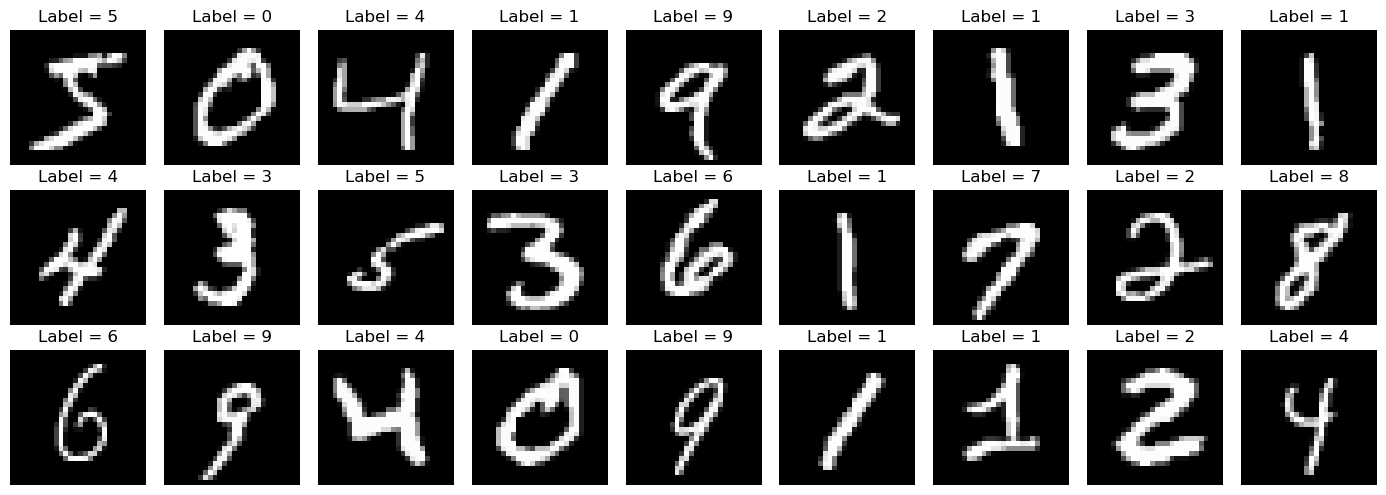

In [3]:
nrows, ncols = 3, 9
fig, ax = plt.subplots(nrows, ncols, figsize=(14, 5))
ax = ax.flatten()
for i in range(nrows*ncols):
    ax[i].set_title(f"Label = {train_dataset[i][1]}")
    ax[i].imshow(train_dataset[i][0].reshape((28, 28)), cmap="gray")
    ax[i].axis("off")
plt.tight_layout()

In [4]:
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class CNNClassifier(pl.LightningModule):
    
    def __init__(self, input_size: int, num_classes: int = 10) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        self.training_step_losses = []
        
    def forward(self, x):
        return self.fc(x)
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch) -> STEP_OUTPUT:
        x, y = batch
        out = self.forward(x)
        loss = F.cross_entropy(out, y)
        self.training_step_losses.append(loss.item())
        return loss
    
    def on_train_epoch_end(self) -> None:
        epoch_loss = torch.tensor(self.training_step_losses).float().mean()
        self.log("train_loss", epoch_loss, prog_bar=True)
        self.training_step_losses = []

input_size = trainloader.dataset[0][0].shape[-1]
model = CNNClassifier(input_size)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_dataloaders=trainloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | fc   | Sequential | 109 K 
------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [5]:
from sklearn.metrics import classification_report

def validate_model(model: nn.Module, dataloader: DataLoader):
    model.eval()
    predicted, true_labels = [],[]
    with torch.no_grad():
        for (x, y) in tqdm(dataloader):
            out = model(x)
            predicted.append(torch.argmax(out, dim=1).detach().cpu().numpy())
            true_labels.append(y.detach().cpu().numpy())
        
    predicted, true_labels = np.concatenate(predicted), np.concatenate(true_labels)

    print(classification_report(true_labels, predicted))
    
validate_model(model, testloader)

  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.95      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.97       958
           7       0.96      0.98      0.97      1028
           8       0.99      0.93      0.96       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [80]:
from typing import Any


class MaskedAutoEncoder(pl.LightningModule):
    
    def __init__(self, input_size: int, latent_size: int = 128, mask_rate: float = 0.8) -> None:
        super().__init__()
        self.mask_rate = mask_rate
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            # nn.Linear(512, 256),
            # nn.ReLU(),
            nn.Linear(256, latent_size),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.ReLU(),
            # nn.Linear(256, 512),
            # nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Sigmoid(),
        )

        self.training_step_losses = []
        
    def generate_mask(self, x):
        mask = (torch.rand(x.shape) > self.mask_rate).float().to(x.device)
        return mask
    
    def apply_noise(self, x,noise_factor=0.5):
        noise = x+torch.randn_like(x) * noise_factor
        noise = torch.clip(noise,0.,1.)
        return noise
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        lr = 1e-3
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        stepping_batches = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=stepping_batches)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]
    
    def training_step(self, batch) -> STEP_OUTPUT:
        x = batch[0]
        # mask = self.generate_mask(x)
        # x_masked = x * mask
        # x_hat, _ = self.forward(x_masked)
        # loss = F.mse_loss(x_hat[mask.logical_not()], x[mask.logical_not()])
        
        x_noised = self.apply_noise(x)
        x_hat, _ = self.forward(x_noised)
        loss = F.mse_loss(x_hat, x)
        
        self.training_step_losses.append(loss.item())
        return loss
    
    def on_train_epoch_end(self) -> None:
        epoch_loss = torch.tensor(self.training_step_losses).float().mean()
        self.log("train_loss", epoch_loss, prog_bar=True)
        self.training_step_losses = []

input_size = trainloader.dataset[0][0].shape[-1]
mae = MaskedAutoEncoder(input_size, latent_size=128, mask_rate=0.8)
mae_trainer = pl.Trainer(max_epochs=30)
mae_trainer.fit(mae, train_dataloaders=trainloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 233 K 
1 | decoder | Sequential | 468 K 
---------------------------------------
702 K     Trainable params
0         Non-trainable params
702 K     Total params
2.808     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [81]:
def get_embeddings(model: nn.Module, dataloader: DataLoader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for (x, y) in tqdm(dataloader):
            _, embeddded = model(x)
            embeddings.append(embeddded.detach().cpu().numpy())
            labels.append(y.detach().cpu().numpy())
                    
    embeddings, labels = np.concatenate(embeddings), np.concatenate(labels)
    return embeddings, labels

train_embeddings, train_labels = get_embeddings(mae, trainloader)
test_embeddings, test_labels = get_embeddings(mae, testloader)

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<Axes: title={'center': 'Latent space representations'}>

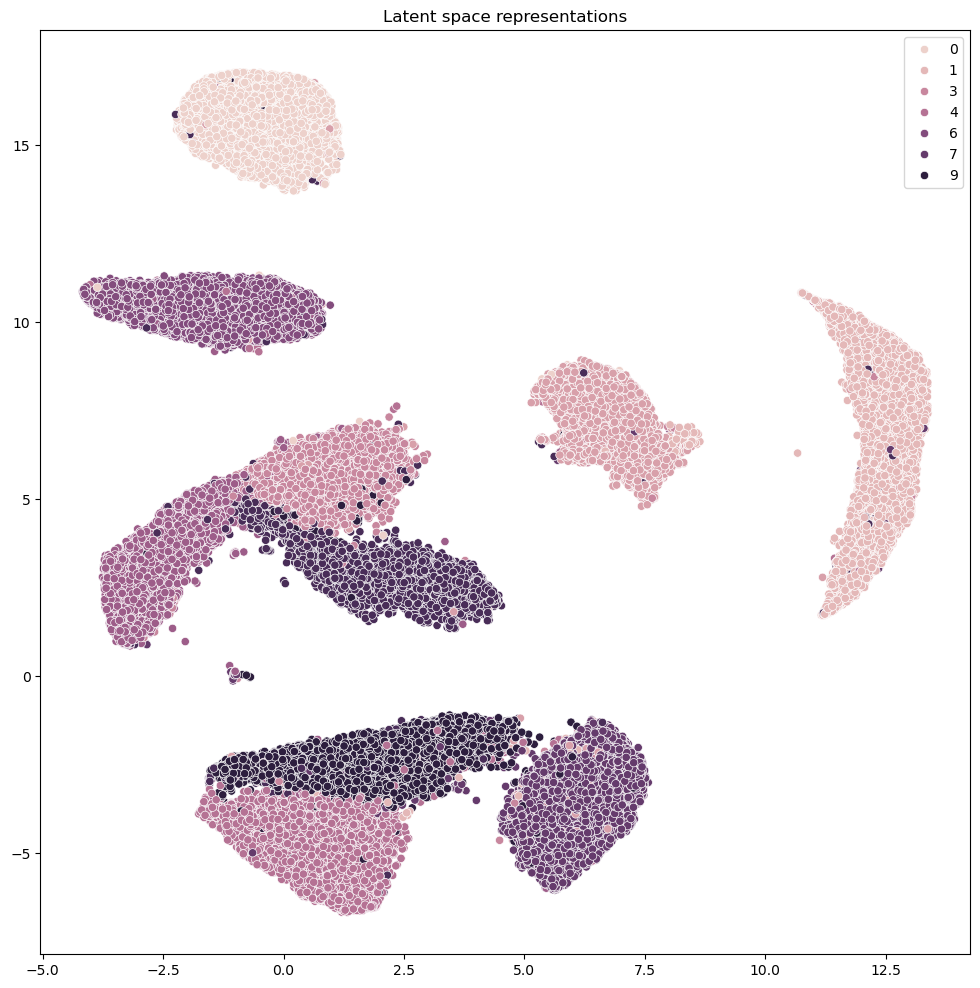

In [82]:
import umap
plane_mapper = umap.UMAP(random_state=42)
manifold = plane_mapper.fit_transform(train_embeddings)
fig, ax = plt.subplots(1,1,figsize=(12, 12))
ax.set_title("Latent space representations")
sns.scatterplot(x=manifold[:, 0], y=manifold[:, 1], hue=train_labels, ax=ax)

In [83]:
train_embeddings_tensor, train_labels_tensor = torch.tensor(train_embeddings).float(), torch.tensor(train_labels).long()
test_embeddings_tensor, test_labels_tensor = torch.tensor(test_embeddings).float(), torch.tensor(test_labels).long()
emb_trainloader = DataLoader(TensorDataset(train_embeddings_tensor, train_labels_tensor), batch_size=BATCH_SIZE, shuffle=True)
emb_testloader = DataLoader(TensorDataset(test_embeddings_tensor, test_labels_tensor), batch_size=BATCH_SIZE, shuffle=False)

input_size = emb_trainloader.dataset[0][0].shape[-1]
emb_model = CNNClassifier(input_size)
embtrainer = pl.Trainer(max_epochs=10, accelerator="cpu")
embtrainer.fit(emb_model, train_dataloaders=emb_trainloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | fc   | Sequential | 25.4 K
------------------------------------
25.4 K    Trainable params
0         Non-trainable params
25.4 K    Total params
0.102     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [84]:
validate_model(model, testloader)

  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.95      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.97       958
           7       0.96      0.98      0.97      1028
           8       0.99      0.93      0.96       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [85]:
validate_model(emb_model, emb_testloader)

  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.96      0.98      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

